<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/Classificadores4-liwc_Coh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix,r2_score, precision_score, recall_score, f1_score,cohen_kappa_score
import time
import warnings
from collections import Counter
from imblearn.over_sampling import ADASYN
warnings.filterwarnings("ignore", category=DeprecationWarning)
import shap
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491644 sha256=a4572402db44e7c7a71a5cd3b7ae01ffece4b93ad9bf0e9a1a01c9b553cbdf2f
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


# Data Acquisition

In [4]:
dataset = pd.read_csv('combined.csv', sep=',')
datasetLi = pd.read_csv('combinedLIWC.csv', sep=',')
datasetCo = pd.read_csv('combined_CohMetrix.csv', sep=',')

# Desbalanceamento

# Data Exploration

In [5]:
dataset.head(20)

,id,feedback,classe
0,23,Ler outros textos sobre o assunto para lher da...,0
1,24,Procure ler mais; para escrever mais acerca do...,0
2,35,Texto bom; precisa apenas ler mais um pouco; p...,0
3,37,Ter cuidado com copias da internet.,0
4,68,Carssimo; o trabalho precisa de uma sistematiz...,1
5,286,Ol Wilma! Na sua postagem no consta o nom...,0
6,665,Faltaram alguns elementos: referncias etc.,0
7,804,Bom dia Ana Lcia! De acordo com a tarefa da we...,1
8,842,Boa tarde Ccero! o motivo da sua pontuao foi i...,1
9,1098,Bom dia!!! cuidado com os erros ortogrficos e ...,0


In [6]:
datasetResult = datasetLi.join(datasetCo)
datasetResult.head()

,id,liwc.funct,liwc.pronoun,liwc.ppron,liwc.i,liwc.we,liwc.you,liwc.shehe,liwc.they,liwc.ipron,liwc.article,liwc.verb,liwc.auxverb,liwc.past,liwc.present,liwc.future,liwc.adverb,liwc.preps,liwc.conj,liwc.negate,liwc.quant,liwc.number,liwc.swear,liwc.social,liwc.family,liwc.friend,liwc.humans,liwc.affect,liwc.posemo,liwc.negemo,liwc.anx,liwc.anger,liwc.sad,liwc.cogmech,liwc.insight,liwc.cause,liwc.discrep,liwc.tentat,liwc.certain,liwc.inhib,...,cm.SMCAUSv,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2
0,23,10,3,1,0,0,1,1,0,3,1,4,1,0,4,1,0,5,1,0,1,0,2,4,0,0,0,1,1,1,0,0,1,9,2,2,2,0,1,4,...,0.0,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN
1,24,8,2,2,0,1,1,1,0,1,1,2,1,1,1,0,0,5,3,0,2,0,1,4,0,0,1,1,0,1,1,0,0,9,0,1,0,1,0,1,...,1.0,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286
2,35,12,3,3,0,0,3,0,3,0,3,2,1,0,2,0,2,4,3,0,2,1,1,4,0,0,3,4,3,0,0,0,0,12,1,1,2,3,2,3,...,1.0,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954
3,37,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,2,0,0,0,0,0,1,...,0.0,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN
4,68,9,4,4,0,0,4,2,2,2,5,4,1,0,4,0,0,3,0,0,1,0,3,6,0,0,1,3,3,0,0,0,0,9,3,1,1,1,1,3,...,0.0,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573


In [7]:
len(datasetResult.columns)

160

In [9]:
datasetResult.shape

(1000, 160)

In [10]:
datasetResult['classe'] = dataset['classe']

In [17]:
#datasetResult.drop(columns=['id'], inplace=True)
datasetResult.drop(columns=['ID'], inplace=True)
datasetResult.head()

,liwc.funct,liwc.pronoun,liwc.ppron,liwc.i,liwc.we,liwc.you,liwc.shehe,liwc.they,liwc.ipron,liwc.article,liwc.verb,liwc.auxverb,liwc.past,liwc.present,liwc.future,liwc.adverb,liwc.preps,liwc.conj,liwc.negate,liwc.quant,liwc.number,liwc.swear,liwc.social,liwc.family,liwc.friend,liwc.humans,liwc.affect,liwc.posemo,liwc.negemo,liwc.anx,liwc.anger,liwc.sad,liwc.cogmech,liwc.insight,liwc.cause,liwc.discrep,liwc.tentat,liwc.certain,liwc.inhib,liwc.incl,...,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
0,10,3,1,0,0,1,1,0,3,1,4,1,0,4,1,0,5,1,0,1,0,2,4,0,0,0,1,1,1,0,0,1,9,2,2,2,0,1,4,2,...,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN,0
1,8,2,2,0,1,1,1,0,1,1,2,1,1,1,0,0,5,3,0,2,0,1,4,0,0,1,1,0,1,1,0,0,9,0,1,0,1,0,1,4,...,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286,0
2,12,3,3,0,0,3,0,3,0,3,2,1,0,2,0,2,4,3,0,2,1,1,4,0,0,3,4,3,0,0,0,0,12,1,1,2,3,2,3,2,...,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954,0
3,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,2,0,0,0,0,0,1,1,...,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN,0
4,9,4,4,0,0,4,2,2,2,5,4,1,0,4,0,0,3,0,0,1,0,3,6,0,0,1,3,3,0,0,0,0,9,3,1,1,1,1,3,1,...,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573,1


In [18]:
datasetResult.shape

(1000, 159)

In [20]:
datasetCurrent = datasetResult

In [21]:
datasetCurrent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 159 entries, liwc.funct to classe
dtypes: float64(63), int64(96)
memory usage: 1.2 MB


In [22]:
pd.options.display.max_columns = None

In [23]:
datasetCurrent.isna().sum(axis=0)

liwc.funct        0
liwc.pronoun      0
liwc.ppron        0
liwc.i            0
liwc.we           0
               ... 
cm.WRDMEAc        0
cm.RDFRE          0
cm.RDFKGL         0
cm.RDL2         165
classe            0
Length: 159, dtype: int64

In [24]:
datasetCurrent.isnull().sum(axis = 1)

0      5
1      0
2      0
3      5
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Length: 1000, dtype: int64

In [25]:
datasetCurrent.isnull().sum().sort_values(ascending = False)

cm.LSASSp      362
cm.LSASSpd     362
cm.RDL2        165
cm.CRFCWO1     165
cm.CRFCWO1d    165
              ... 
cm.CNCNeg        0
cm.CNCPos        0
cm.CNCAdd        0
cm.CNCTemp       0
liwc.funct       0
Length: 159, dtype: int64

In [26]:
datasetCurrent['classe'].value_counts()

1    890
0    110
Name: classe, dtype: int64

In [27]:
datasetCurrent.columns.values

array(['liwc.funct', 'liwc.pronoun', 'liwc.ppron', 'liwc.i', 'liwc.we',
       'liwc.you', 'liwc.shehe', 'liwc.they', 'liwc.ipron',
       'liwc.article', 'liwc.verb', 'liwc.auxverb', 'liwc.past',
       'liwc.present', 'liwc.future', 'liwc.adverb', 'liwc.preps',
       'liwc.conj', 'liwc.negate', 'liwc.quant', 'liwc.number',
       'liwc.swear', 'liwc.social', 'liwc.family', 'liwc.friend',
       'liwc.humans', 'liwc.affect', 'liwc.posemo', 'liwc.negemo',
       'liwc.anx', 'liwc.anger', 'liwc.sad', 'liwc.cogmech',
       'liwc.insight', 'liwc.cause', 'liwc.discrep', 'liwc.tentat',
       'liwc.certain', 'liwc.inhib', 'liwc.incl', 'liwc.excl',
       'liwc.percept', 'liwc.see', 'liwc.hear', 'liwc.feel', 'liwc.bio',
       'liwc.body', 'liwc.health', 'liwc.sexual', 'liwc.ingest',
       'liwc.relativ', 'liwc.motion', 'liwc.space', 'liwc.time',
       'liwc.work', 'liwc.achieve', 'liwc.leisure', 'liwc.home',
       'liwc.money', 'liwc.relig', 'liwc.death', 'liwc.assent',
       'liwc.no

In [28]:

datasetCurrent.dropna(subset = ["cm.RDL2","cm.LSASSp", "cm.LSASSpd"] , inplace=True)

# Machine Learning Models - Training

In [29]:
def cross_validation_result(model,X_train,y_train, X_test, y_test,cv_split=10):
    
    tscv = TimeSeriesSplit(cv_split)
    training_score = cross_val_score(model,X_train,y_train,cv=tscv.n_splits) 
    testing_score = cross_val_score(model,X_test,y_test,cv=tscv.n_splits)
    print("Cross-val Training score:", training_score.mean())
    print("Cross-val Testing score:", testing_score.mean())
    training_predictions = cross_val_predict(model,X_train,y_train,cv=tscv.n_splits)
    testing_predictions = cross_val_predict(model,X_test,y_test,cv=tscv.n_splits)
    
    training_accuracy = r2_score(y_train,training_predictions) 
    test_accuracy = r2_score(y_test,testing_predictions)
    
    print ("Training-predictions accuracy:",training_accuracy)  
    print ("Test-predictions accuracy:",test_accuracy)

    f1_score_model = f1_score(y_test, testing_predictions, average="macro")
    print("F1 score",f1_score_model)
    precision_score_model = precision_score(y_test, testing_predictions, average="macro")
    print("Precision score",precision_score_model)
    recall_score_model = recall_score(y_test, testing_predictions, average="macro")
    print("Recall score",recall_score_model)
    return training_accuracy,test_accuracy,f1_score_model,precision_score_model,recall_score_model


In [30]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(datasetCurrent.drop('classe', axis=1))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(sdss, datasetCurrent['classe'], test_size=0.33)

In [32]:
counter = Counter(y_train)
print(counter)

Counter({1: 398, 0: 29})


In [33]:
counter = Counter(y_test)
print(counter)

Counter({1: 198, 0: 13})


In [34]:
oversample = ADASYN()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [35]:
counter = Counter(y_train)
print(counter)

Counter({0: 404, 1: 398})


In [36]:
counter = Counter(y_test)
print(counter)

Counter({1: 198, 0: 198})


*K Nearest Neighbors¶*

In [37]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_knn = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_knn, testing_acc_knn,f1_score_knn,precision_score_knn,recall_score_knn= cross_validation_result(knn,X_train,y_train,X_test,y_test)
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("kappa_knn", kappa_knn)  
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Cross-val Training score: 0.9052469135802468
Cross-val Testing score: 0.8758333333333332
Training-predictions accuracy: 0.6209264142494652
Test-predictions accuracy: 0.505050505050505
F1 score 0.8743386329048344
Precision score 0.9008097165991903
Recall score 0.8762626262626263
Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 82.07
kappa_knn 0.6414141414141414
Time consumed for training: 0.009 seconds
Time consumed for prediction: 0.10286 seconds


*Naive Bayes*

In [38]:
#from sklearn.preprocessing import MaxAbsScaler
#scaler_gnb = MaxAbsScaler()
#sdss = scaler_gnb.fit_transform(datasetCurrent.drop('classe', axis=1))
#X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, datasetCurrent['classe'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_gnb = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_gnb, testing_acc_gnb,f1_score_gnb,precision_score_gnb,recall_score_gnb = cross_validation_result(gnb,X_train,y_train,X_test,y_test)
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("kappa_gnb", kappa_gnb)
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Cross-val Training score: 0.9439197530864197
Cross-val Testing score: 0.9243589743589744
Training-predictions accuracy: 0.7755485347529728
Test-predictions accuracy: 0.696969696969697
F1 score 0.9241476184395352
Precision score 0.9263740771123872
Recall score 0.9242424242424242
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 60.61
kappa_gnb 0.21212121212121215
Time consumed for training: 0.007 seconds
Time consumed for prediction: 0.00584 seconds


*XGBoost*

In [39]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_xgb = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_xgb, testing_acc_xgb,f1_score_xgb,precision_score_xgb,recall_score_xgb = cross_validation_result(xgb,X_train,y_train,X_test,y_test)
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("kappa_xgb", kappa_xgb)
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

Cross-val Training score: 0.9800925925925927
Cross-val Testing score: 0.9924358974358973
Training-predictions accuracy: 0.9201950345788348
Test-predictions accuracy: 0.9696969696969697
F1 score 0.9924241941140834
Precision score 0.9924368033058695
Recall score 0.9924242424242424
XGBoost's prediction accuracy is: 77.27
kappa_xgb 0.5454545454545454
Time consumed for training: 0.587
Time consumed for prediction: 0.00265 seconds


*Scitkit-Learn's Random Forest Classifier*

In [40]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_rfc = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_rfc, testing_acc_rfc,f1_score_rfc,precision_score_rfc,recall_score_rfc  = cross_validation_result(rfc,X_train,y_train,X_test,y_test)
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("kappa_rfc", kappa_rfc)
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Cross-val Training score: 0.9800771604938271
Cross-val Testing score: 0.9898717948717948
Training-predictions accuracy: 0.915207224240012
Test-predictions accuracy: 0.9292929292929293
F1 score 0.9823222177581358
Precision score 0.9824339839265213
Recall score 0.9823232323232323
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 69.44
kappa_rfc 0.38888888888888884
Time consumed for training: 0.043 seconds
Time consumed for prediction: 0.00256 seconds


Support Vector Machine Classifier

In [41]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_svc = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_svc, testing_acc_svc, f1_score_svc,precision_score_svc,recall_score_svc  = cross_validation_result(svc,X_train,y_train,X_test,y_test)
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("kappa_svc", kappa_svc)
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Cross-val Training score: 0.9502006172839506
Cross-val Testing score: 0.8711538461538462
Training-predictions accuracy: 0.800487586447087
Test-predictions accuracy: 0.48484848484848486
F1 score 0.870311506675143
Precision score 0.8818181818181818
Recall score 0.8712121212121212
Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 82.07
kappa_svc 0.6414141414141414
Time consumed for training: 0.084 seconds
Time consumed for prediction: 0.03651 seconds


In [42]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Acurácia': [testing_acc_knn, testing_acc_gnb, testing_acc_xgb, testing_acc_rfc, testing_acc_svc],
    'Kappa': [kappa_knn, kappa_gnb, kappa_xgb, kappa_rfc, kappa_svc],
    'F1' : [f1_score_knn, f1_score_gnb, f1_score_xgb, f1_score_rfc, f1_score_svc],
    'Precisão' : [precision_score_knn, precision_score_gnb, precision_score_xgb, precision_score_rfc, precision_score_svc],
    'Revocação' : [recall_score_knn, recall_score_gnb, recall_score_xgb, recall_score_rfc, recall_score_svc]})
result_df = results.sort_values(by='Acurácia', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Acurácia,Kappa,F1,Precisão,Revocação
Model,,,,,
XGBoost,0.969697,0.545455,0.992424,0.992437,0.992424
Random Forest,0.929293,0.388889,0.982322,0.982434,0.982323
Naive Bayes,0.696970,0.212121,0.924148,0.926374,0.924242
KNN,0.505051,0.641414,0.874339,0.900810,0.876263
SVC,0.484848,0.641414,0.870312,0.881818,0.871212


In [43]:
explainer = shap.Explainer(xgb.predict, X_test)
shap_values = explainer(X_train)

Permutation explainer: 803it [15:09,  1.14s/it]


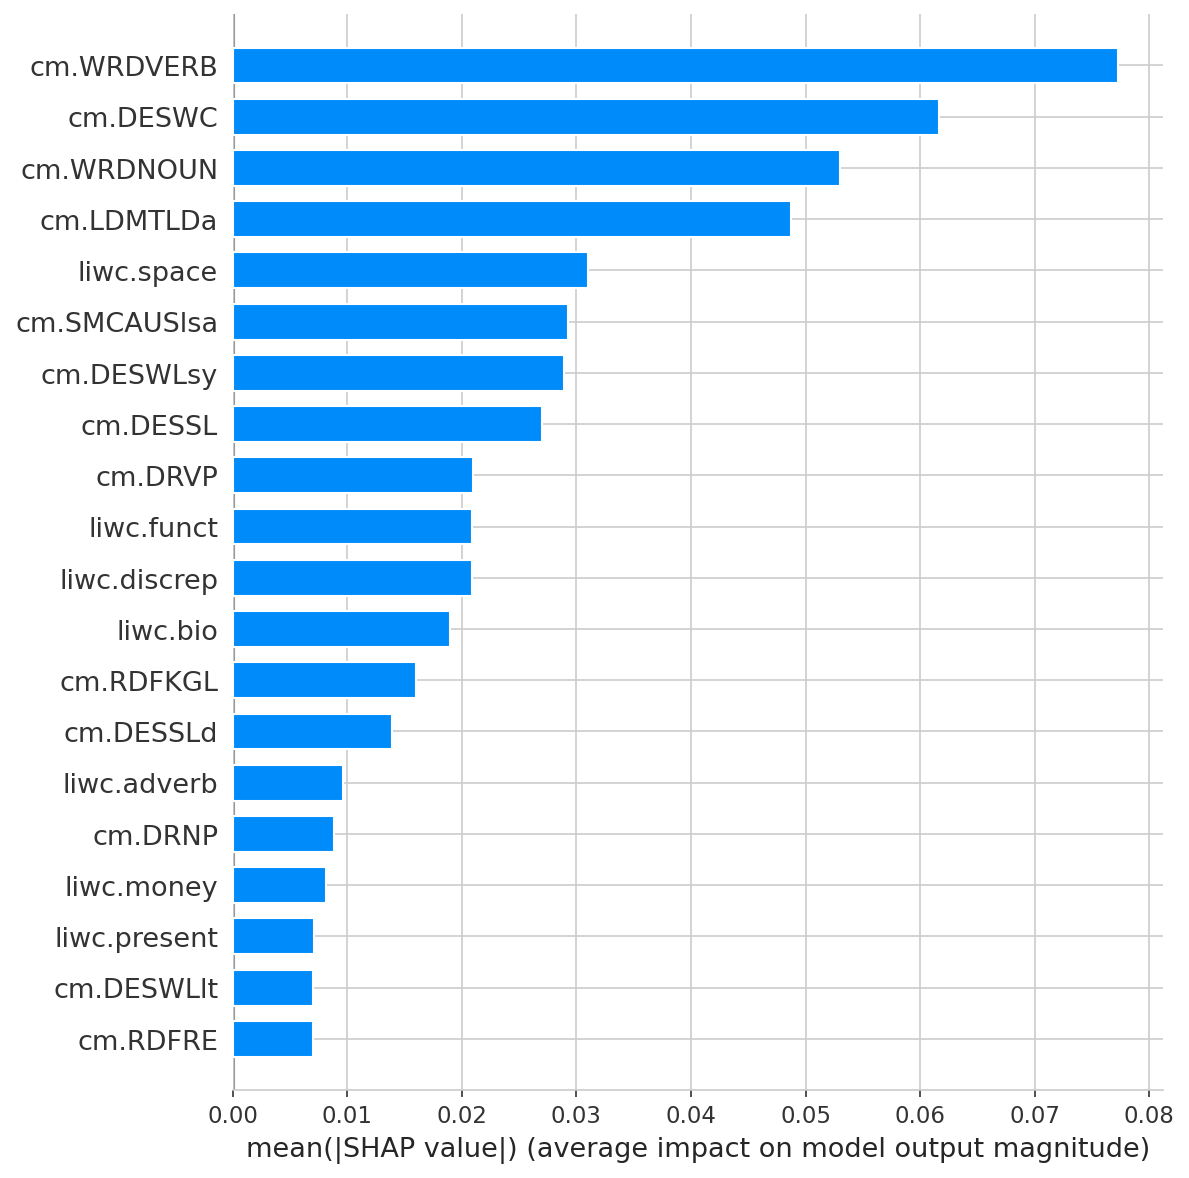

In [44]:
plt.figure(figsize = (15,8))
ax = shap.summary_plot(shap_values, 
                       datasetCurrent.columns,
                       plot_type='bar')
plt.show()

In [ ]:
type(shap_values)

shap._explanation.Explanation

In [ ]:
clustering = shap.utils.hclust(X_train, y_train)

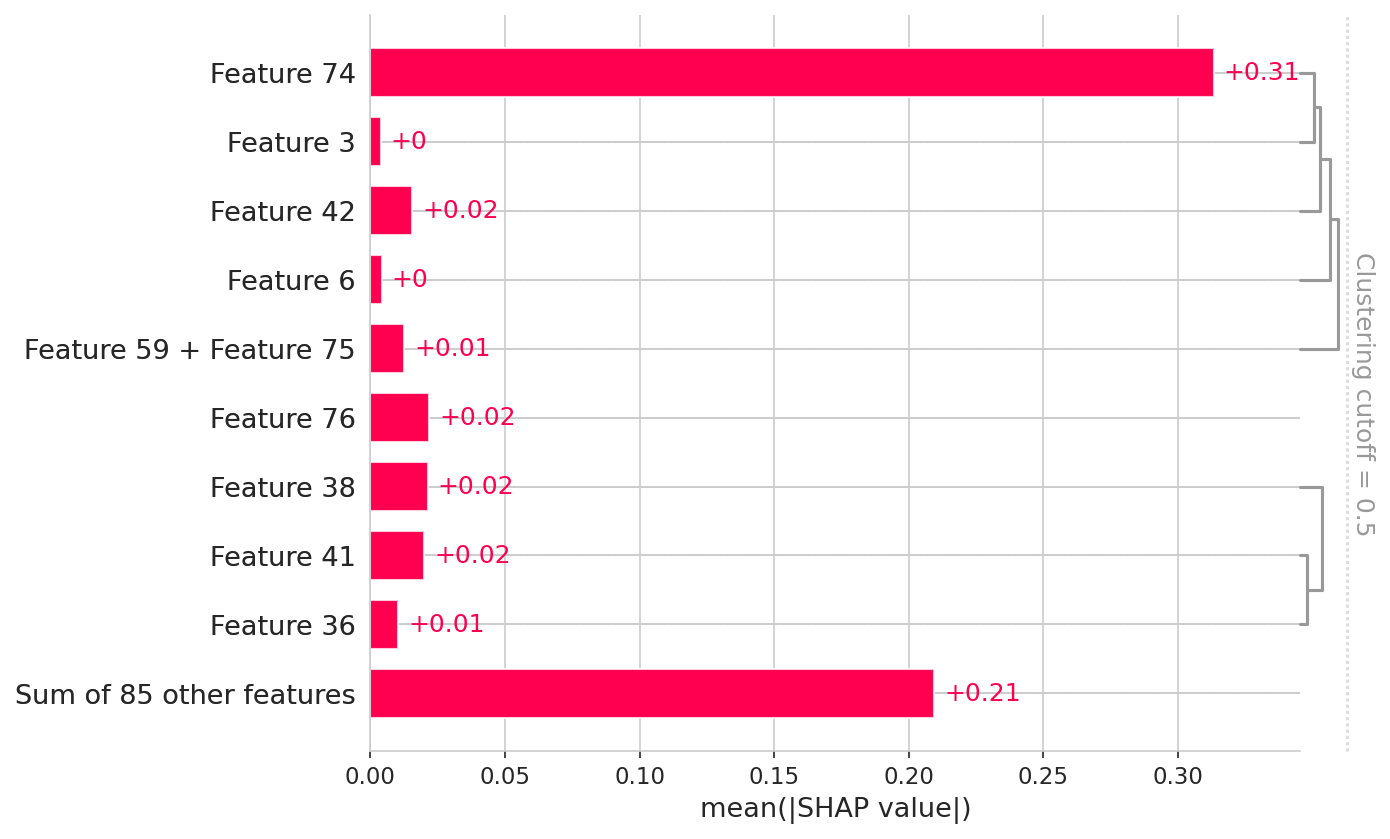

In [ ]:
shap.plots.bar(shap_values, clustering=clustering)

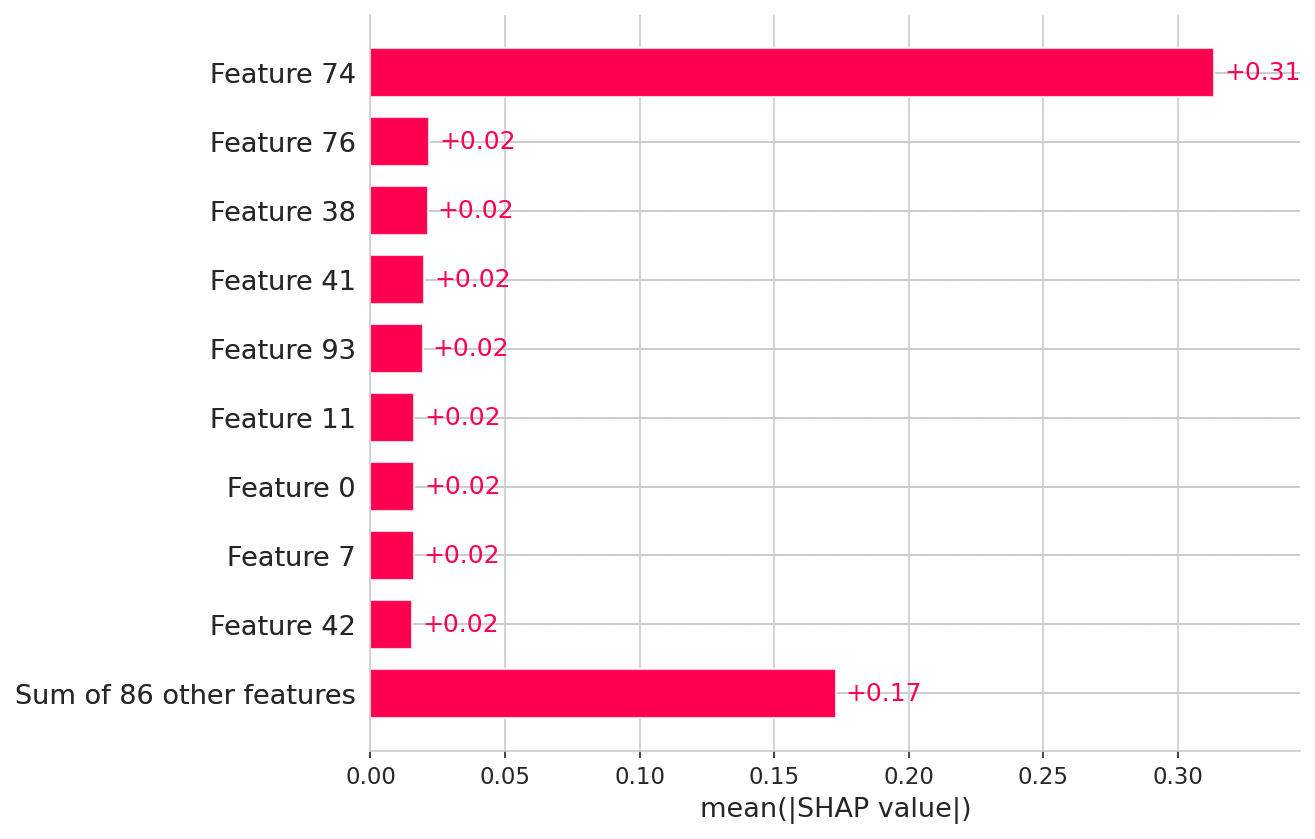

In [ ]:
shap.plots.bar(shap_values, max_display=10)

Cross Validation - Scikit-Learn's Random Forest Classifier

In [ ]:
#from sklearn.model_selection import cross_val_score
#rfc_cv = RandomForestClassifier(n_estimators=100)
#scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

Scores: [0.96875    0.97916667 0.95833333 1.         0.98947368 0.98947368
 0.98947368 1.         0.96842105 0.98947368]
Mean: 0.9832565789473684
Standard Deviation: 0.013355609745452359


XGBoost

In [ ]:
#xgb_cv = XGBClassifier(n_estimators=100)
#scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

Scores: [0.95348837 0.93023256 0.93023256 0.93023256 0.93023256 0.95348837
 0.95348837 0.95238095 1.         0.97619048]
Mean: 0.9509966777408637
Standard Deviation: 0.02186593140604478


The best parameters for prediction as found by the tuning tests are:

max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 0.005

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datasetCurrent.drop('classe', axis=1), datasetCurrent['classe'],
                                                   test_size=0.33)

In [ ]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 97.63


In [ ]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.97674419 0.97674419 0.93023256 0.93023256 0.95348837 0.90697674
 0.93023256 0.97619048 0.88095238 0.92857143]
Mean: 0.9390365448504984
Standard Deviation: 0.03029299003555244


# XGBoost - Evaluation

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 200, 1: 198}

In [ ]:
predictions = cross_val_predict(xgb, X_test, y_test, cv=5)
confusion_matrix(y_test, predictions)

array([[198,   2],
       [  8, 190]])

In [ ]:
print("Precision:", precision_score(y_test, predictions, average='micro'))
print("Recall:",recall_score(y_test, predictions, average='micro'))

Precision: 0.9748743718592965
Recall: 0.9748743718592965


In [ ]:
print("F1-Score:", f1_score(y_test, predictions, average='micro'))

F1-Score: 0.9748743718592965
